In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from botorch.acquisition import UpperConfidenceBound
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_target_function(train_X):
    return torch.sin(train_X * (2 * np.pi)) # + 0.15 * torch.randn_like(train_X)

In [3]:
def BO_procedure(train_X, train_Y, bounds=torch.tensor([[0.0], [1.0]])):
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)

    UCB = UpperConfidenceBound(gp, beta=0.5)  # higher beta means more exploration (example: 10000)

    candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )

    candidate_y = calculate_target_function(candidate)
    print(f'    Candidate: ({candidate[0][0].numpy()}, {candidate_y[0][0].numpy()})')

    new_X = torch.cat([train_X, candidate])
    new_Y = torch.cat([train_Y, candidate_y])

    return gp, new_X, new_Y

In [4]:
def plot(model, train_X, train_Y):
    from matplotlib import pyplot as plt
    %matplotlib inline

    target_x = torch.linspace(0, 1, 101)
    target_y = calculate_target_function(target_x)

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))
    # test model on 101 regular spaced points on the interval [0, 1]
    test_X = torch.linspace(0, 1, 101)
    # no need for gradients
    with torch.no_grad():
        # plot target function (inclusion of noise decreases accuracy)
        ax.plot(target_x.cpu().numpy(), target_y.cpu().numpy(), 'r')

        # compute posterior
        posterior = model.posterior(test_X)
        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        # Plot training points as black stars
        ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
        # Plot posterior means as blue line
        ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)

    ax.legend(['Target Function', 'Observed Data', 'Mean', 'Confidence'])
    plt.tight_layout()

Executing Iteration 1:
    Candidate: (0.5000067353248596, -4.2287512769689783e-05)
Executing Iteration 2:
    Candidate: (0.24941210448741913, 0.9999932050704956)
Executing Iteration 3:
    Candidate: (0.2501124441623688, 0.9999997615814209)
Executing Iteration 4:
    Candidate: (0.29062193632125854, 0.9676039218902588)
Executing Iteration 5:
    Candidate: (0.2589466869831085, 0.9984204173088074)


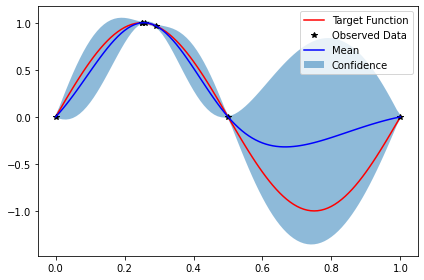

In [5]:
NUM_ITERATIONS = 5

train_X = torch.linspace(0, 1, 2).unsqueeze(1)
train_Y = calculate_target_function(train_X)
for i in range(NUM_ITERATIONS):
    print(f'Executing Iteration {i + 1}:')
    model, train_X, train_Y = BO_procedure(train_X, train_Y)

plot(model, train_X, train_Y)